In [15]:
import pandas as pd

df = pd.read_csv("output.csv")
df.columns

Index([' rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [16]:
# Drop unneeded columns
columns_to_remove = [" rating", "date", "variation"]
df.drop(columns=columns_to_remove, inplace=True)

# Check for missing values
df.isna().sum()

# Separate features and labels
X = df["verified_reviews"]
y = df["feedback"]

# Clean up common contractions and extra characters
def clean_text(text):
    if not isinstance(text, str):
        return ""

    substitutions = {
        r"what's": "what is",
        r"\'s": " is",
        r"\'ve": " have",
        r"can't": "cannot",
        r"n't": " not",
        r"i'm": "i am",
        r"\'re": " are",
        r"\'d": " would",
        r"\'ll": " will",
        r"\'scuse": " excuse"
    }
    for pattern, replacement in substitutions.items():
        text = re.sub(pattern, replacement, text)

    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Comprehensive text preprocessing pipeline
def preprocess_text(text_list):
    # Convert to lowercase and remove unwanted patterns
    text_list = [t.lower() for t in text_list]
    text_list = [re.sub(r"https?://\S+|www\.\S+", "", t) for t in text_list]  # Remove URLs
    text_list = [re.sub(r"<.*?>", "", t) for t in text_list]  # Remove HTML tags
    text_list = [re.sub(r'[^\x00-\x7f]', '', t) for t in text_list]  # Remove non-ASCII

    # Remove emojis and punctuation
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # pictographs
        u"\U0001F680-\U0001F6FF"  # transport
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text_list = [emoji_pattern.sub('', t) for t in text_list]
    text_list = [t.translate(str.maketrans('', '', string.punctuation)) for t in text_list]

    # Remove digits
    text_list = [t.translate(str.maketrans('', '', string.digits)) for t in text_list]

    # Tokenize and remove stopwords (if using stop_words and lemmatizer)
    tokenized = [t.split() for t in text_list]
    tokenized = [[word for word in tokens if word not in stop_words] for tokens in tokenized]
    lemmatized = [' '.join([lemmatizer.lemmatize(word) for word in tokens]) for tokens in tokenized]

    return lemmatized


In [17]:
import nltk
nltk.download('wordnet')         # For lemmatization
nltk.download('omw-1.4')         # WordNet lemmatizer dependencies

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Step 1: Clean the text (expand contractions, remove punctuation, etc.)
X_cleaned = X.apply(clean_text)

# Step 2: Tokenize the cleaned text
tokenized_text = X_cleaned.apply(lambda x: x.split())

# Step 3: Apply full preprocessing (e.g., stopword removal, lemmatization)
final_processed_text = tokenized_text.apply(preprocess_text)

# View first processed example
print(final_processed_text.iloc[0])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['love', '', 'echo']


['love', '', 'echo']

In [24]:
import numpy as np

# Set portion for training data
train_ratio = 0.8
train_size = int(len(final_processed_text) * train_ratio)

# Split processed text and corresponding labels
train_data = final_processed_text[:train_size]
train_labels = np.array(y[:train_size])

val_data = final_processed_text[train_size:]
val_labels = np.array(y[train_size:])

# Print dataset sizes
print("Training samples:", len(train_data))
print("Training labels:", len(train_labels))
print("Validation samples:", len(val_data))
print("Validation labels:", len(val_labels))


Training samples: 2520
Training labels: 2520
Validation samples: 630
Validation labels: 630


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Define tokenizer parameters
vocab_limit = 1000
unknown_token = "<OOV>"

# Initialize and train tokenizer
tokenizer = Tokenizer(num_words=vocab_limit, oov_token=unknown_token)
tokenizer.fit_on_texts(train_data)

# Extract and view vocabulary dictionary
word_index = tokenizer.word_index
print("Sample of word index:", dict(list(word_index.items())[:10]))


Sample of word index: {'<OOV>': 1, '': 2, 'love': 3, 'echo': 4, 'great': 5, 'alexa': 6, 'work': 7, 'like': 8, 'music': 9, 'use': 10}


In [27]:
# Convert training text data into sequences of integer tokens
train_sequences = tokenizer.texts_to_sequences(train_data)

# Display the tokenized result for the first training example
print("Tokenized first training sample:", train_sequences[0])


Tokenized first training sample: [3, 2, 4]


In [28]:
# Set parameters for embedding and sequence formatting
embedding_dim = 32         # Size of embedding vectors
max_length = 50            # Max number of tokens per input sequence
truncating_style = 'post'  # Cut off tokens from the end if too long
padding_style = 'post'     # Add padding tokens at the end of sequences


In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Apply padding and truncation to make all sequences the same length
train_padded = pad_sequences(
    train_sequences,
    maxlen=max_length,
    padding=padding_style,
    truncating=truncating_style
)

# Show original and padded lengths for the first sequence
print("Original length:", len(train_sequences[0]))
print("Padded length:", len(train_padded[0]))


Original length: 3
Padded length: 50


In [30]:
# Preview the first 100 token-to-index mappings from the vocabulary
sample_vocab = dict(list(word_index.items())[:100])
print("Sample vocabulary (first 100 words):")
print(sample_vocab)


Sample vocabulary (first 100 words):
{'<OOV>': 1, '': 2, 'love': 3, 'echo': 4, 'great': 5, 'alexa': 6, 'work': 7, 'like': 8, 'music': 9, 'use': 10, 'sound': 11, 'one': 12, 'device': 13, 'easy': 14, 'product': 15, 'good': 16, 'amazon': 17, 'set': 18, 'dot': 19, 'thing': 20, 'get': 21, 'would': 22, 'speaker': 23, 'time': 24, 'show': 25, 'bought': 26, 'home': 27, 'light': 28, 'play': 29, 'new': 30, 'really': 31, 'still': 32, 'day': 33, 'smart': 34, 'much': 35, 'better': 36, 'prime': 37, 'also': 38, 'well': 39, 'quality': 40, 'room': 41, 'fun': 42, 'far': 43, 'need': 44, 'tv': 45, 'screen': 46, 'plus': 47, 'even': 48, 'video': 49, 'alarm': 50, 'got': 51, 'could': 52, 'buy': 53, 'spot': 54, 'feature': 55, 'hub': 56, 'everything': 57, 'house': 58, 'turn': 59, 'voice': 60, 'learning': 61, 'clock': 62, 'able': 63, 'make': 64, 'ask': 65, 'using': 66, 'see': 67, 'say': 68, 'nice': 69, 'little': 70, 'used': 71, 'want': 72, 'weather': 73, 'know': 74, 'way': 75, 'lot': 76, 'many': 77, 'setup': 78, 

In [32]:
# Convert validation text data into integer sequences using the same tokenizer
validation_sequences = tokenizer.texts_to_sequences(val_data)

# Pad or truncate the validation sequences to match the training sequence length
validation_padded = pad_sequences(
    validation_sequences,
    maxlen=max_length,
    padding=padding_style,
    truncating=truncating_style
)

# Display number of validation samples and the padded shape
print("Total validation sequences:", len(validation_sequences))
print("Shape of padded validation data:", validation_padded.shape)


Total validation sequences: 630
Shape of padded validation data: (630, 50)


In [33]:
# Create a reverse lookup dictionary to map integers back to words
reverse_word_index = {index: word for word, index in word_index.items()}

# Function to convert a sequence of token IDs back into words
def decode_sequence(token_list):
    return ' '.join([reverse_word_index.get(token, '?') for token in token_list])

# Example: decode the first padded training sequence
print("Decoded sequence:")
print(decode_sequence(train_padded[0]))
print("---")
print("Original cleaned text:")
print(train_data.iloc[0])


Decoded sequence:
love  echo ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
Original cleaned text:
['love', '', 'echo']


In [34]:
import torch
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(SentimentRNN, self).__init__()
        self.hidden_dim = hidden_dim

        # Embedding layer maps token IDs to dense vectors
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

        # Simple RNN layer
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)

        # Final classification layer
        self.fc = nn.Linear(hidden_dim, 2)  # Binary classification: [0, 1]

    def forward(self, input):
        # input shape: (batch_size, sequence_length)
        embedded = self.embedding(input)

        # Initial hidden state: (num_layers, batch_size, hidden_dim)
        hidden = torch.zeros(1, input.size(0), self.hidden_dim).to(input.device)

        # RNN output: output is (batch_size, seq_len, hidden_dim)
        output, hidden = self.rnn(embedded, hidden)

        # Take the output from the final time step
        final_output = self.fc(output[:, -1, :])
        return final_output


In [35]:
class AttentionSentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(AttentionSentimentRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 2)  # Two output classes

    def forward(self, x):
        embedded = self.embedding(x)
        hidden = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        output, _ = self.rnn(embedded, hidden)

        # Attention: compute weights and apply to RNN outputs
        attn_weights = torch.softmax(self.attention(output).squeeze(-1), dim=1)
        context = torch.sum(attn_weights.unsqueeze(-1) * output, dim=1)

        return self.fc(context)


In [37]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to torch tensors
X_train = torch.tensor(train_padded, dtype=torch.long)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_val = torch.tensor(validation_padded, dtype=torch.long)
y_val = torch.tensor(val_labels, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionSentimentRNN(vocab_size=1000, embed_dim=32, hidden_dim=64).to(device)

criterion = nn.CrossEntropyLoss()  # For multi-class logits (2 classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 24.3382
Epoch 2, Loss: 22.2838
Epoch 3, Loss: 22.0251
Epoch 4, Loss: 21.3672
Epoch 5, Loss: 19.9615


In [39]:
model.eval()
all_preds = []
all_true = []
misclassified = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

        # Store misclassified examples
        for i in range(len(batch_y)):
            if preds[i] != batch_y[i]:
                misclassified.append((batch_x[i].cpu().numpy(), preds[i].item(), batch_y[i].item()))

# Accuracy
correct = sum(p == t for p, t in zip(all_preds, all_true))
accuracy = correct / len(all_true)
print(f"Validation Accuracy: {accuracy:.2%}")


Validation Accuracy: 92.54%


In [40]:
print("\nSample Misclassified Reviews:")
for i in range(3):
    tokens = misclassified[i][0]
    pred_label = misclassified[i][1]
    true_label = misclassified[i][2]
    decoded = decode_sequence(tokens)
    print(f"Predicted: {pred_label}, Actual: {true_label}\nReview: {decoded}\n---")



Sample Misclassified Reviews:
Predicted: 1, Actual: 0
Review: ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
Predicted: 1, Actual: 0
Review: cheap  cheap sound ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
Predicted: 0, Actual: 1
Review: <OOV> excelente <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> internet <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> internet ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---


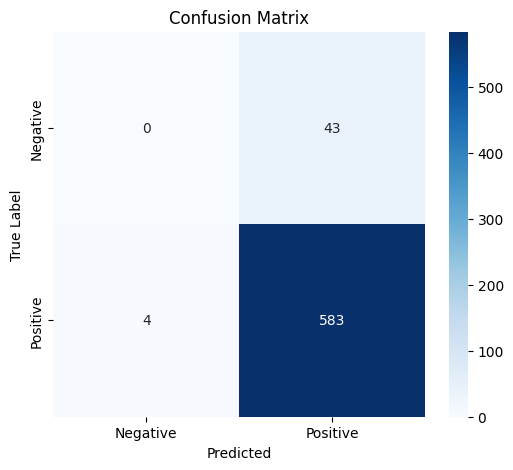

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Replace with your actual predictions and labels
conf_mat = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


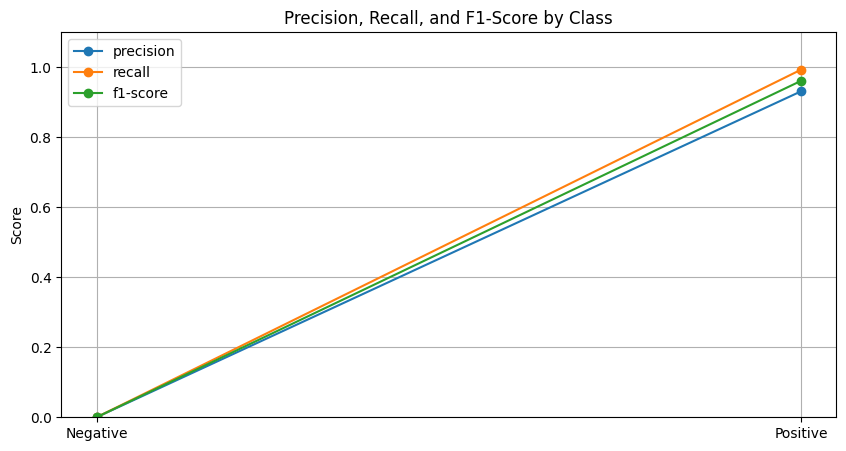

In [42]:
report = classification_report(all_true, all_preds, output_dict=True)

# Extract metrics
labels = ['precision', 'recall', 'f1-score']
classes = ['0', '1']  # '0' = Negative, '1' = Positive
metrics = {metric: [report[cls][metric] for cls in classes] for metric in labels}

# Plot
plt.figure(figsize=(10, 5))
for metric in labels:
    plt.plot(classes, metrics[metric], marker='o', label=metric)
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.ylim(0, 1.1)
plt.title("Precision, Recall, and F1-Score by Class")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(5):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

    train_losses.append(epoch_loss)
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_outputs = model(val_x)
            v_loss = criterion(val_outputs, val_y)
            val_loss += v_loss.item()

            val_preds = torch.argmax(val_outputs, dim=1)
            val_correct += (val_preds == val_y).sum().item()
            val_total += val_y.size(0)

    val_losses.append(val_loss)
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc = {train_accuracies[-1]:.2f}, Val Acc = {val_accuracies[-1]:.2f}")


Epoch 1: Train Acc = 0.92, Val Acc = 0.94
Epoch 2: Train Acc = 0.93, Val Acc = 0.93
Epoch 3: Train Acc = 0.93, Val Acc = 0.94
Epoch 4: Train Acc = 0.93, Val Acc = 0.94
Epoch 5: Train Acc = 0.94, Val Acc = 0.94


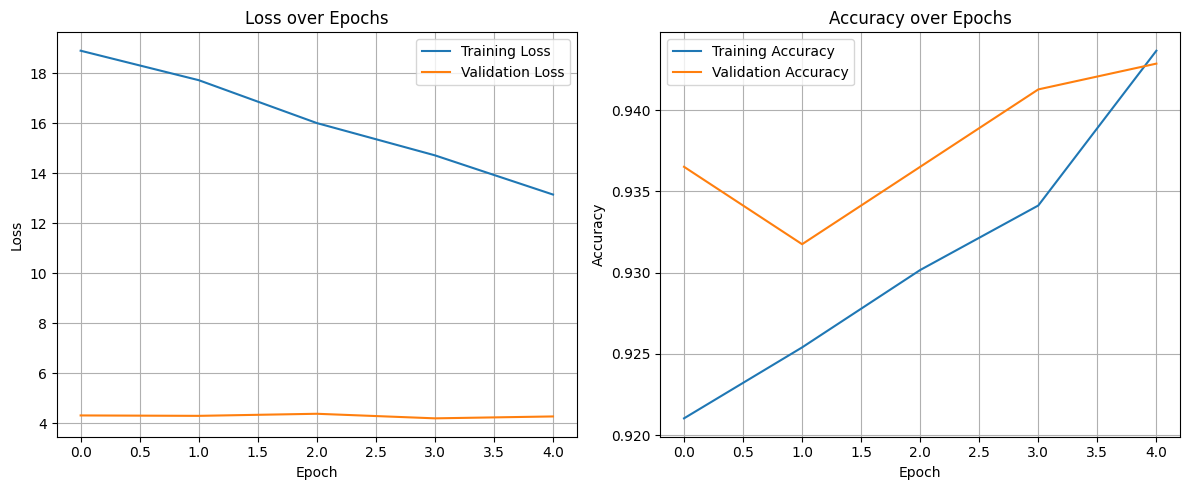

In [44]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
